# **PLANO DE SAÚDE: LIGHT GBM**



### Instalação de bibliotecas

In [ ]:
# Apenas a biblioteca shap precisa ser instalada; as demais utilizadas neste notebook já vêm pré-instaladas no Google Colab
! pip install shap

### Carregamento de bibliotecas

In [ ]:
from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler         # Balanceamento de classes
import lightgbm as lgb                                         # Light GBM
from sklearn.model_selection import KFold, cross_validate      # Validação cruzada
from sklearn.model_selection import RandomizedSearchCV         # Otimização de hiperparâmetros via random search
import shap                                                    # Interpretabilidade de modelos de ML

### Leitura da base de dados

In [ ]:
dados_plano = pd.read_table("Plano_Saude.txt", sep = "\t")

In [ ]:
# Reordenação de categorias da variável resposta
dados_plano['STATUS'] = pd.Categorical(dados_plano['STATUS'], categories = ['CancInvol', 'CancVol', 'Down', 'Mantem', 'Up'], ordered = True)

### Visualização da base de dados

In [ ]:
display(dados_plano)

,ID_CLIENTE,NIVEL_SATISFACAO,RELACAO_CUSTO_RENDA,QTDE_UTILIZACOES_12M,TEMPO_PLANO,QTDE_SERVICOS_12M,QTDE_ATRASOS_12M,FLAG_MUDANCA_RESIDENCIA_12M,QTDE_RECLAMACOES_12M,QTDE_DEPENDENTES,IDADE,STATUS
0,CLI000001,7.7,0.11,6,4.4,3,0,Nao,0,2,78,Mantem
1,CLI000002,9.8,0.49,3,3.3,1,0,Nao,0,1,21,Mantem
2,CLI000003,6.2,0.12,4,6.4,1,0,Nao,0,0,1,Up
3,CLI000004,7.4,0.35,15,5.6,1,2,Nao,3,0,10,Mantem
4,CLI000005,0.3,0.25,26,3.5,2,2,Nao,0,1,89,Up
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,CLI099996,9.4,0.39,10,3.6,1,6,Nao,2,0,26,CancInvol
99996,CLI099997,9.2,0.25,3,6.3,2,0,Nao,1,0,42,Up
99997,CLI099998,9.6,0.09,5,8.0,2,2,Nao,1,0,23,Mantem
99998,CLI099999,5.2,0.43,2,5.9,1,0,Sim,0,0,33,Mantem


### Separação de features e target

In [ ]:
X = dados_plano.drop(columns = ['STATUS', 'ID_CLIENTE'])
y = dados_plano['STATUS']

### Criação de colunas dummy para variáveis explicativas qualitativas

In [ ]:
X = pd.get_dummies(X, drop_first = True)

### Balanceamento de base de dados grande (undersampling)

In [ ]:
# Contagem de valores na variável resposta antes do balanceamento
y.value_counts()

,count
STATUS,
Mantem,67000
Up,13000
Down,10000
CancInvol,6000
CancVol,4000


In [ ]:
# Balanceamento
rus = RandomUnderSampler(random_state = 123)
X_sample, y_sample = rus.fit_resample(X, y)

In [ ]:
# Contagem de valores na variável resposta após o balanceamento
y_sample.value_counts()

,count
STATUS,
CancInvol,4000
CancVol,4000
Down,4000
Mantem,4000
Up,4000


### Modelo 1: Light GBM com otimização de hiperparâmetros via validação cruzada, com random search

In [ ]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'n_estimators': np.arange(10, 201, 10),
    'learning_rate': np.arange(0.01, 0.51, 0.01),
    'max_depth': np.arange(2, 11),
    'min_data_in_leaf': np.arange(100, 1001)
}

In [ ]:
# Busca da melhor combinação de hiperparâmetros, via validação cruzada com random search, com otimização de AUC-OVR e k = 5 (EXECUÇÃO ONEROSA)
lightgbm = lgb.LGBMClassifier(class_weight = 'balanced', verbose = -1, random_state = 123)
cv = KFold(n_splits = 5, shuffle = True, random_state = 123)
scoring = {'AUC_OVR': 'roc_auc_ovr', 'balanced_accuracy': 'balanced_accuracy'}
random_search = RandomizedSearchCV(lightgbm, param_grid, cv = cv, scoring = scoring, refit = 'AUC_OVR', n_iter = 100, random_state = 123)
random_search.fit(X_sample, y_sample)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
                   estimator=LGBMClassifier(class_weight='balanced',
                                            random_state=123, verbose=-1),
                   n_iter=100,
                   param_distributions={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 ,...
        958,  959,  960,  961,  962,  963,  964,  965,  966,  967,  968,
        969,  970,  971,  972,  973,  974,  975,  976,  977,  978,  979,
        980,  981,  982,  983,  984,  985,  986,  987,  988,  989,  990,
        991,  992,  993,  994,  995,  996,  997,  998,  999, 1000]),
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200])},
                   random_state=123, refit='AUC_OVR',
                   scoring={'AUC_OVR': 'roc_auc_ovr',
                            'balanced_accuracy': 'balanced_accuracy'})

In [ ]:
# Melhor configuração de hiperparâmetros identificada
print(random_search.best_params_)

{'n_estimators': 160, 'min_data_in_leaf': 426, 'max_depth': 2, 'learning_rate': 0.2}


In [ ]:
# Tabela com todas as combinações de hiperparâmetros testadas, ordenadas do maior para o menor AUC-OVR médio nos conjuntos de teste
resultados_grid = pd.DataFrame(random_search.cv_results_)
resultados_grid = resultados_grid[['params',
                                   'mean_test_AUC_OVR', 'std_test_AUC_OVR', 'rank_test_AUC_OVR',
                                   'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 'rank_test_balanced_accuracy']].sort_values(by = 'rank_test_AUC_OVR')
resultados_grid

,params,mean_test_AUC_OVR,std_test_AUC_OVR,rank_test_AUC_OVR,mean_test_balanced_accuracy,std_test_balanced_accuracy,rank_test_balanced_accuracy
8,"{'n_estimators': 160, 'min_data_in_leaf': 426,...",0.906946,0.001063,1,0.664403,0.002617,1
2,"{'n_estimators': 150, 'min_data_in_leaf': 382,...",0.906313,0.000997,2,0.662568,0.001897,5
60,"{'n_estimators': 150, 'min_data_in_leaf': 482,...",0.906298,0.001435,3,0.662873,0.002434,4
22,"{'n_estimators': 120, 'min_data_in_leaf': 366,...",0.906289,0.001113,4,0.663180,0.002504,3
6,"{'n_estimators': 110, 'min_data_in_leaf': 244,...",0.906108,0.001331,5,0.664271,0.001878,2
...,...,...,...,...,...,...,...
29,"{'n_estimators': 50, 'min_data_in_leaf': 391, ...",0.885221,0.001705,96,0.626557,0.005522,95
55,"{'n_estimators': 30, 'min_data_in_leaf': 876, ...",0.884719,0.001767,97,0.629572,0.006120,91
5,"{'n_estimators': 190, 'min_data_in_leaf': 319,...",0.883679,0.000462,98,0.621560,0.002914,98
23,"{'n_estimators': 180, 'min_data_in_leaf': 409,...",0.881604,0.000831,99,0.615287,0.002002,100


In [ ]:
# Modelo final a partir da melhor combinação de hiperparâmetros
lightgbm_1 = random_search.best_estimator_

### Estimativa de desempenho do modelo 1 em dados totalmente apartados, via validação cruzada aninhada

In [ ]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'n_estimators': np.arange(10, 201, 10),
    'learning_rate': np.arange(0.01, 0.51, 0.01),
    'max_depth': np.arange(2, 11),
    'min_data_in_leaf': np.arange(100, 1001)
}

In [38]:
# Validação cruzada estratificada aninhada com grid search e otimização de AUC-OVR, k1 = 2 e k2 = 5 (EXECUÇÃO ONEROSA)
lightgbm = lgb.LGBMClassifier(class_weight = 'balanced', verbose = -1, random_state = 123)
inner_cv = KFold(n_splits = 2, shuffle = True, random_state = 123)
outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 123)

scoring = {'AUC_OVR': 'roc_auc_ovr', 'balanced_accuracy': 'balanced_accuracy'}
random_search = RandomizedSearchCV(lightgbm, param_grid, cv = inner_cv, scoring = scoring, refit = 'AUC_OVR', n_iter = 100, random_state = 123)
nested_scores = cross_validate(random_search, X = X_sample, y = y_sample, cv = outer_cv, scoring = scoring)

In [39]:
# AUC das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC-OVR), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_AUC_OVR'].round(3))
print("Média de AUC-OVR: " + str(round(np.mean(nested_scores['test_AUC_OVR']), 3)))
print("D.P. de AUC-OVR: " + str(round(np.std(nested_scores['test_AUC_OVR']), 3)))

[0.906 0.905 0.908 0.908 0.908]
Média de AUC-OVR: 0.907
D.P. de AUC-OVR: 0.001


In [40]:
# Acurácia balanceada das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC-OVR), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_balanced_accuracy'].round(3))
print("Média de Acurácia Balanceada: " + str(round(np.mean(nested_scores['test_balanced_accuracy']), 3)))
print("D.P. de Acurácia Balanceada: " + str(round(np.std(nested_scores['test_balanced_accuracy']), 3)))

[0.666 0.667 0.664 0.66  0.667]
Média de Acurácia Balanceada: 0.665
D.P. de Acurácia Balanceada: 0.002


### Aplicação do modelo final de Light GBM na base de dados



In [32]:
# Atribuição das probabilidades preditas por categoria
lightgbm_1.fit(X, y)
y_prob = pd.DataFrame(lightgbm_1.predict_proba(X)[:,:], columns = lightgbm_1.classes_)
dados_plano = pd.concat([dados_plano, y_prob], axis = 1)

In [33]:
# Atribuição da categoria predita
dados_plano['y_pred'] = lightgbm_1.predict(X)

In [34]:
# Matriz de classificação absoluta: observado versus predito
pd.crosstab(dados_plano['STATUS'], dados_plano['y_pred'], rownames = ['Observado'], colnames = ['Predito'])

Predito,CancInvol,CancVol,Down,Mantem,Up
Observado,,,,,
CancInvol,4639,696,320,260,85
CancVol,487,2956,356,168,33
Down,779,1339,5921,1722,239
Mantem,4299,3654,10244,34495,14308
Up,366,165,263,2269,9937


In [35]:
# Matriz de classificação relativa: observado versus predito
pd.crosstab(dados_plano['STATUS'], dados_plano['y_pred'], rownames = ['Observado'], colnames = ['Predito'], normalize = 'index').round(2)

Predito,CancInvol,CancVol,Down,Mantem,Up
Observado,,,,,
CancInvol,0.77,0.12,0.05,0.04,0.01
CancVol,0.12,0.74,0.09,0.04,0.01
Down,0.08,0.13,0.59,0.17,0.02
Mantem,0.06,0.05,0.15,0.51,0.21
Up,0.03,0.01,0.02,0.17,0.76


### Importância das features do modelo final

In [ ]:
# Cálculo de medida de importância de Gini
importancias = lightgbm_1.feature_importances_
features = X.columns

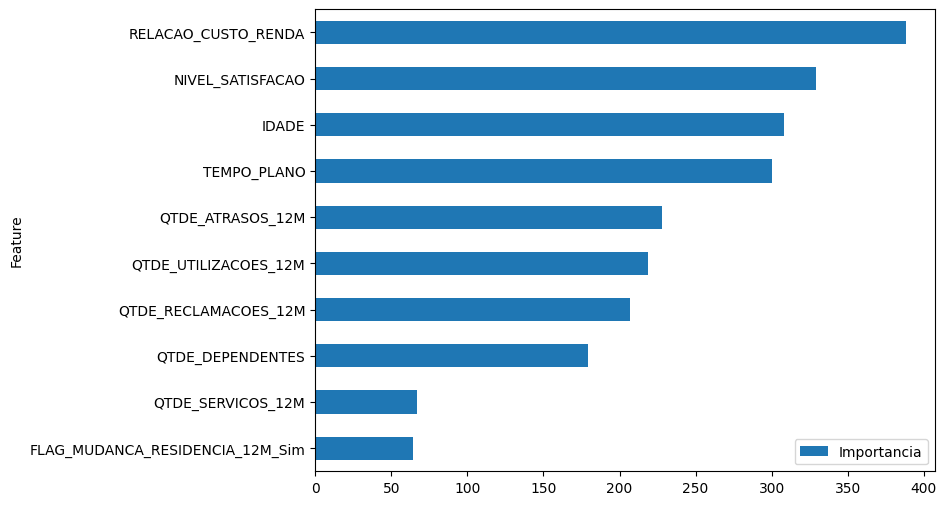

In [ ]:
# Gráfico das importâncias de Gini
df_importancias = pd.DataFrame({'Feature': features, 'Importancia': importancias}).sort_values(by = 'Importancia', ascending = True)
df_importancias.plot.barh(x = 'Feature', y = 'Importancia', figsize = (8, 6))
plt.show()

In [41]:
# Cálculo de valores SHAP para as observações
explainer = shap.Explainer(lightgbm_1)
valores_shap = explainer(X)

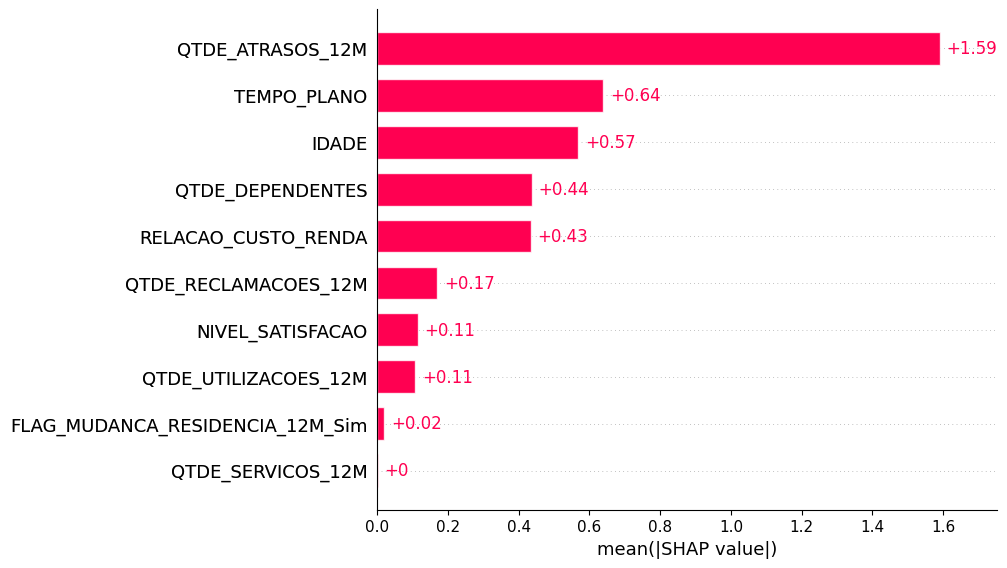

In [43]:
# Gráfico do SHAP absoluto médio por feature: categoria 'CancInvol'
shap.plots.bar(valores_shap[:,:,0])

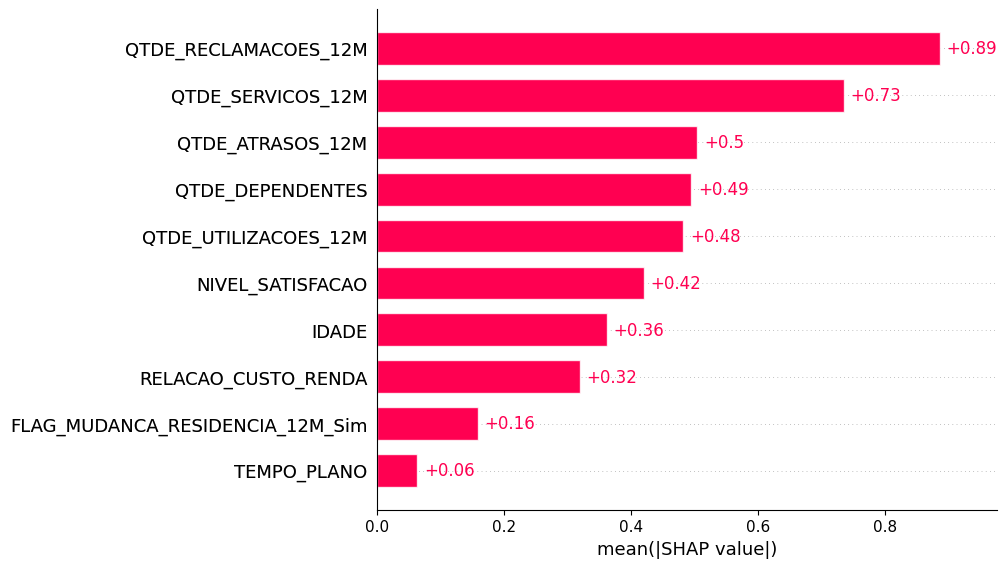

In [23]:
# Gráfico do SHAP absoluto médio por feature: categoria 'CancVol'
shap.plots.bar(valores_shap[:,:,1])

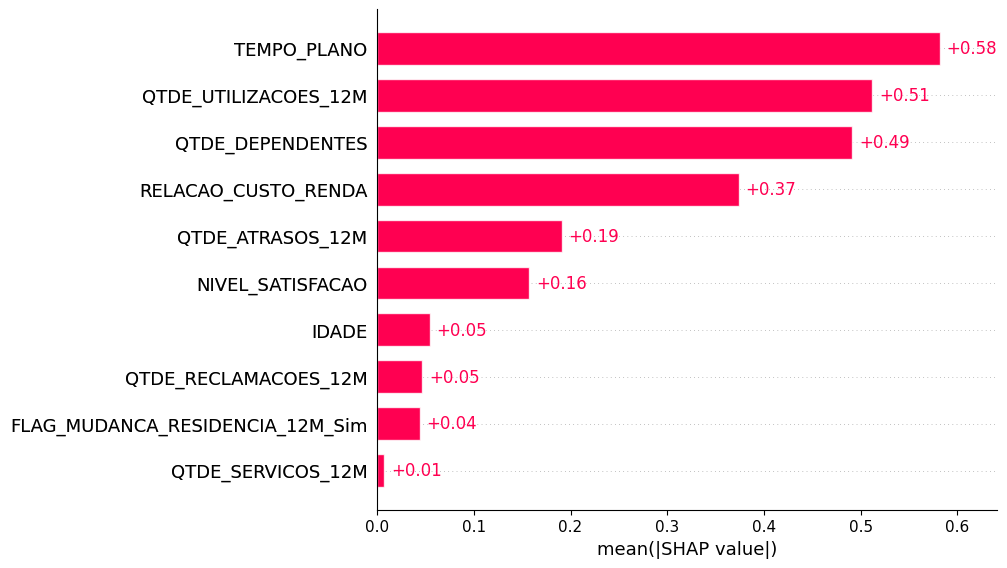

In [24]:
# Gráfico do SHAP absoluto médio por feature: categoria 'Down'
shap.plots.bar(valores_shap[:,:,2])

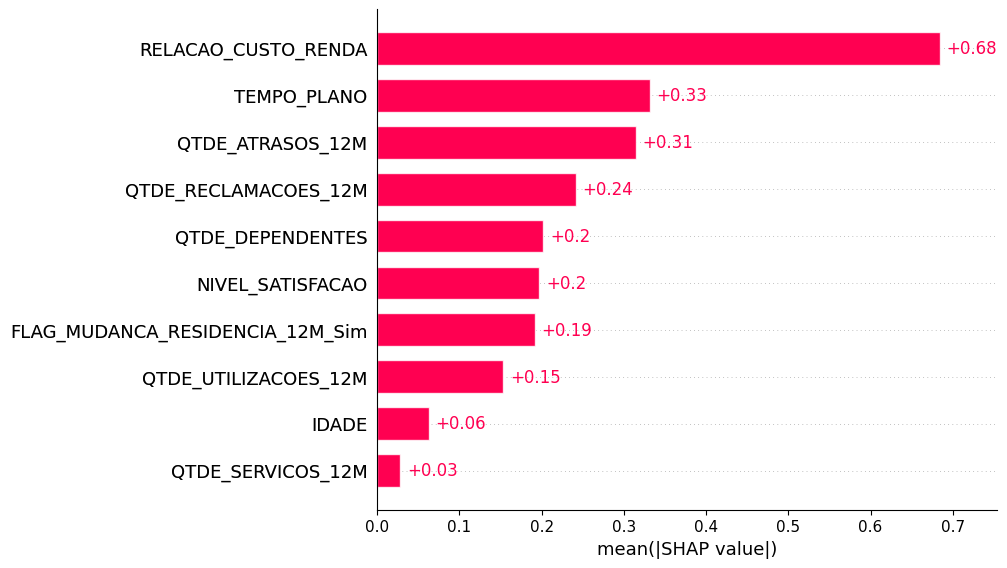

In [25]:
# Gráfico do SHAP absoluto médio por feature: categoria 'Mantem'
shap.plots.bar(valores_shap[:,:,3])

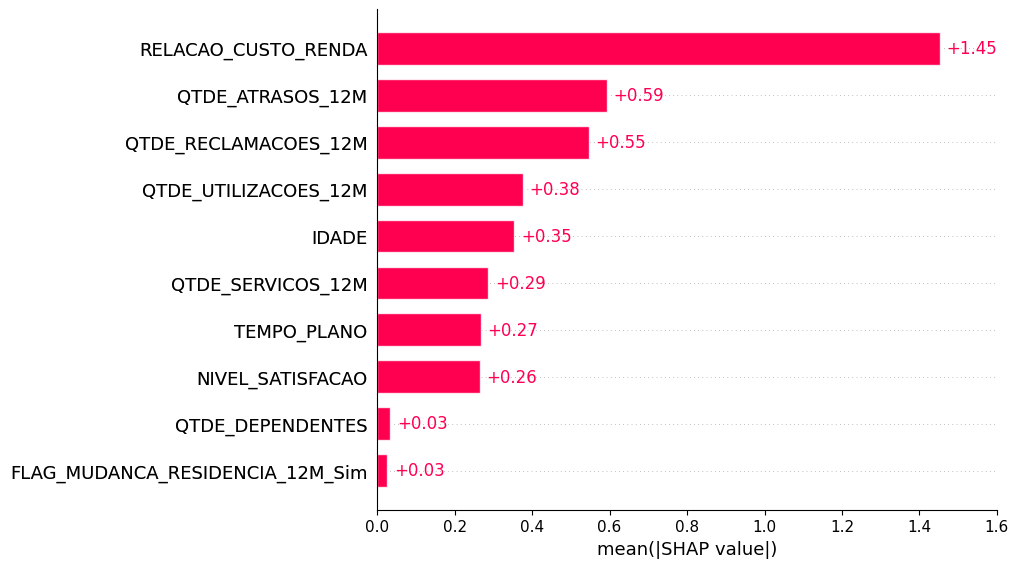

In [26]:
# Gráfico do SHAP absoluto médio por feature: categoria 'Up'
shap.plots.bar(valores_shap[:,:,4])

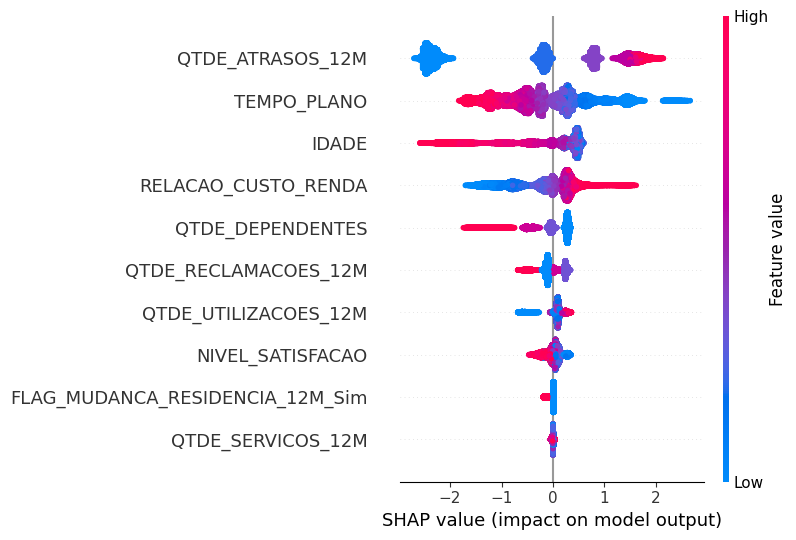

In [27]:
# Gráfico de distribuição de valores SHAP por feature: "enxame de abelhas" (beeswarm plot): categoria 'CancInvol'
shap.summary_plot(valores_shap[:,:,0])

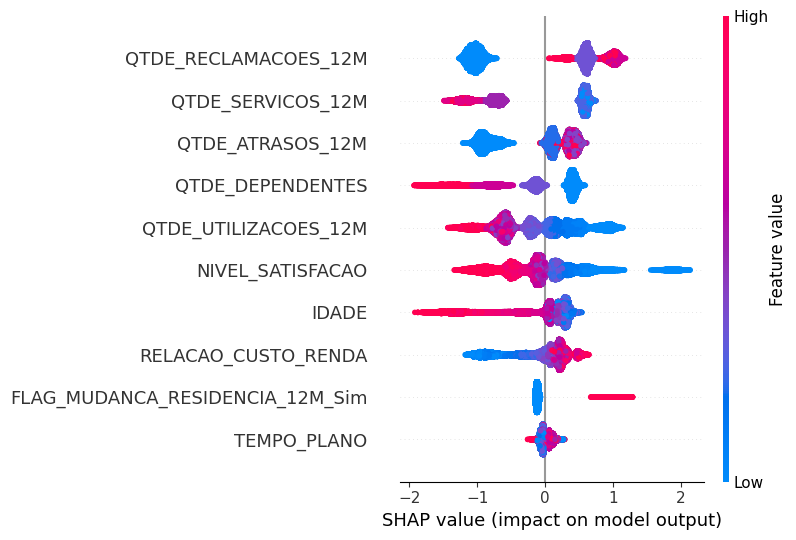

In [28]:
# Gráfico de distribuição de valores SHAP por feature: "enxame de abelhas" (beeswarm plot): categoria 'CancVol'
shap.summary_plot(valores_shap[:,:,1])

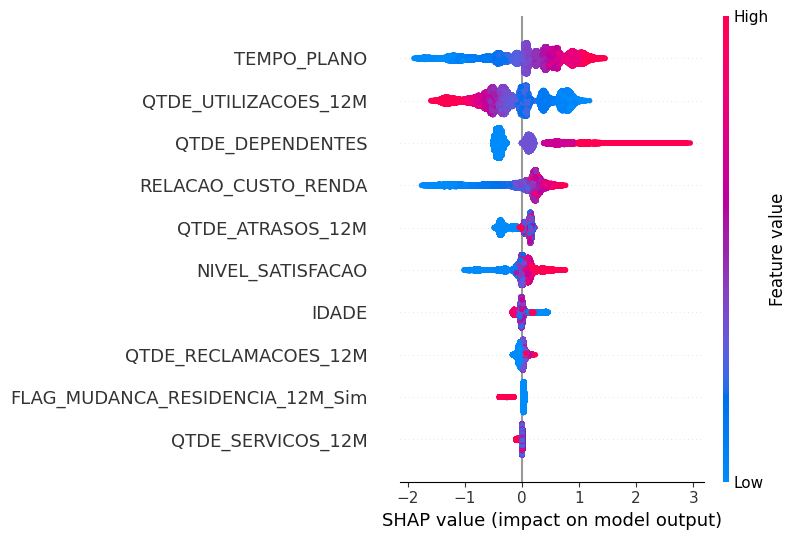

In [29]:
# Gráfico de distribuição de valores SHAP por feature: "enxame de abelhas" (beeswarm plot): categoria 'Down'
shap.summary_plot(valores_shap[:,:,2])

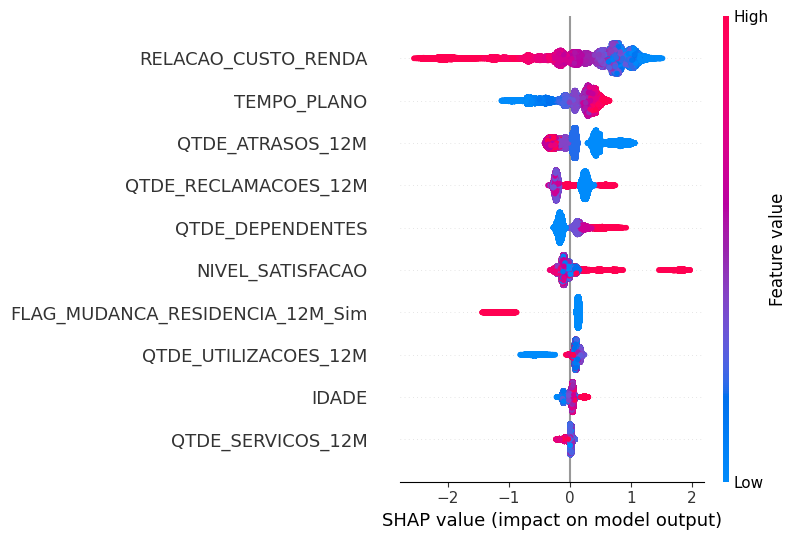

In [30]:
# Gráfico de distribuição de valores SHAP por feature: "enxame de abelhas" (beeswarm plot): categoria 'Mantem'
shap.summary_plot(valores_shap[:,:,3])

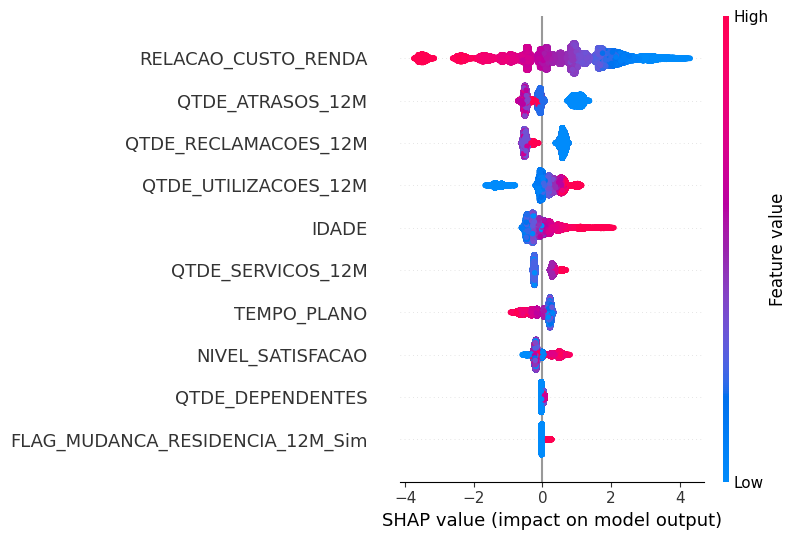

In [31]:
# Gráfico de distribuição de valores SHAP por feature: "enxame de abelhas" (beeswarm plot): categoria 'Up'
shap.summary_plot(valores_shap[:,:,4])